## Introduction

Autoencoders encode an input into a latent space and decode the latent representation into an output. This output is often referred to as **the reconstruction**, as the primary goal is to reconstruct the input from the latent code.

Autoencoders are a very popular for data compression due to their ability to efficiently capture and represent the essential features of the input data in a compact form.

One problem that autoencoders face is the lack of variation. This means that while they can effectively compress and reconstruct data, they struggle to generate new, diverse samples that resemble the original data. The latent space learned by traditional autoencoders can be sparse and disjointed, leading to poor generalization and limited ability to produce meaningful variations of the input data.

## What do we mean by variation?

In the context of generative models, variation refers to the ability to produce a diverse range of outputs from a given latent space. For instance, in image generation, variation means creating different but plausible images that share common characteristics with the training data.

Traditional autoencoders, while good at reconstruction, do not inherently encourage this diversity. They tend to map inputs to specific points in the latent space, which can limit the model's ability to explore and generate new samples.

Introducing Variational Autoencoders (VAEs) as a Solution:
Variational Autoencoders (VAEs) address this limitation by introducing a probabilistic approach to the encoding process. Instead of mapping inputs to fixed points in the latent space, VAEs map inputs to a distribution over the latent space. This allows for a smoother and more continuous representation of the data, fostering better generalization and enabling the generation of diverse outputs.

Here's a high-level overview of how VAEs work:

- Encoder: Maps the input data to a mean and variance that define a Gaussian distribution in the latent space.
- Sampling: Samples a point from this Gaussian distribution.
- Decoder: Uses the sampled point to reconstruct the input data, ensuring that the output is a plausible variation of the input.

In the next sections of this blog post, we talk about the technical details of setting up and training a VAE. We will also explore how the Lance data format can be leveraged to optimize data handling, ensuring efficient and scalable workflows.

By integrating VAEs with Lance, you can unlock new possibilities in data compression, generation, and management, pushing the boundaries of what is achievable with machine learning.

## Setup and Imports

In [1]:
!pip install -U -q pylance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.7/28.7 MB 66.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import io

from PIL import Image
from tqdm import tqdm


from matplotlib import pyplot as plt

import requests
import tarfile
import os
import time

import pyarrow as pa
import lance

## Configuration

Here we define the configuration for our experiment. Please feel free to change the configuration and check the outputs yourself!

In [3]:
vae_config = {
    "BATCH_SIZE": 128,
    "IN_RESOLUTION": 32,
    "IN_CHANNELS": 3,
    "NUM_EPOCHS": 50,
    "LEARNING_RATE": 1e-3,
    "LATENT_DIM_SIZE": 128,
}

## Dataset

This section of the blog post is taken from [Lance Deep Learning Recepies](https://github.com/lancedb/lance-deeplearning-recipes/blob/main/examples/image-classification/image-classification.ipynb).

Here we will download the CINC-10 dataset and convert it into a Lance dataset. After we have that, we will use our `PyTorch` dataloader to load the dataset into our training pipeline.

In [4]:
# Define the URL for the dataset file
data_url = "https://datashare.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz"

# Create the data directory if it doesn't exist
data_dir = "cinic-10-data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download the dataset file
print("Downloading CINIC-10 dataset...")
data_file = os.path.join(data_dir, "CINIC-10.tar.gz")

response = requests.get(data_url, stream=True)
total_size = int(response.headers.get('content-length', 0))
block_size = 1024

start_time = time.time()
progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

with open(data_file, 'wb') as f:
    for chunk in response.iter_content(chunk_size=block_size):
        if chunk:
            f.write(chunk)
            progress_bar.update(len(chunk))

end_time = time.time()
download_time = end_time - start_time
progress_bar.close()

print(f"\nDownload time: {download_time:.2f} seconds")

# Extract the dataset files
print("Extracting dataset files...")
with tarfile.open(data_file, 'r:gz') as tar:
    tar.extractall(path=data_dir)

print("Dataset downloaded and extracted successfully!")

100%|██████████| 688M/688M [04:58<00:00, 2.30MiB/s]



Download time: 298.99 seconds
Extracting dataset files...
Dataset downloaded and extracted successfully!


In [5]:
def process_images(images_folder, split, schema):

    # Iterate over the categories within each data type
    label_folder = os.path.join(images_folder, split)
    for label in os.listdir(label_folder):
        label_folder = os.path.join(images_folder, split, label)

        # Iterate over the images within each label
        for filename in tqdm(os.listdir(label_folder), desc=f"Processing {split} - {label}"):
            # Construct the full path to the image
            image_path = os.path.join(label_folder, filename)

            # Read and convert the image to a binary format
            with open(image_path, 'rb') as f:
                binary_data = f.read()

            image_array = pa.array([binary_data], type=pa.binary())
            filename_array = pa.array([filename], type=pa.string())
            label_array = pa.array([label], type=pa.string())
            split_array = pa.array([split], type=pa.string())

            # Yield RecordBatch for each image
            yield pa.RecordBatch.from_arrays(
                [image_array, filename_array, label_array, split_array],
                schema=schema
            )

# Function to write PyArrow Table to Lance dataset
def write_to_lance(images_folder, dataset_name, schema):
    for split in ['test', 'train', 'valid']:
        lance_file_path = os.path.join(images_folder, f"{dataset_name}_{split}.lance")

        reader = pa.RecordBatchReader.from_batches(schema, process_images(images_folder, split, schema))
        lance.write_dataset(
            reader,
            lance_file_path,
            schema,
        )


dataset_path = "cinic-10-data"
dataset_name = os.path.basename(dataset_path)

start = time.time()
schema = pa.schema([
    pa.field("image", pa.binary()),
    pa.field("filename", pa.string()),
    pa.field("label", pa.string()),
    pa.field("split", pa.string())
])

start = time.time()
write_to_lance(dataset_path, dataset_name, schema)
end = time.time()
print(f"Time(sec): {end - start:.2f}")

Processing valid - bird: 100%|██████████| 9000/9000 [00:01<00:00, 6398.85it/s]

Time(sec): 40.47


In [12]:
def draw_image_grid(samples):
    images = samples[:4]
    images = (images * 0.5) + 0.5  # Unnormalize the images to [0, 1] range
    grid_img = torchvision.utils.make_grid(images, nrow=2)
    plt.figure(figsize=(5, 5))
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')
    plt.show()

In [7]:
class CustomImageDataset(data.Dataset):
    def __init__(self, classes, lance_dataset, transform=None):
        self.classes = classes
        self.ds = lance.dataset(lance_dataset)
        self.transform = transform

    def __len__(self):
        return self.ds.count_rows()

    def __getitem__(self, idx):
        raw_data = self.ds.take([idx], columns=['image', 'label']).to_pydict()
        img_data, label = raw_data['image'][0], raw_data['label'][0]

        img = Image.open(io.BytesIO(img_data))

        # Convert grayscale images to RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = self.classes.index(label)
        return img, label

In [8]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

lance_train_dataset = CustomImageDataset(
    classes,
    "cinic-10-data/cinic-10-data_train.lance/",
    transform=train_transform
)

lance_train_loader = torch.utils.data.DataLoader(
    lance_train_dataset,
    batch_size=vae_config["BATCH_SIZE"],
    shuffle=True
)

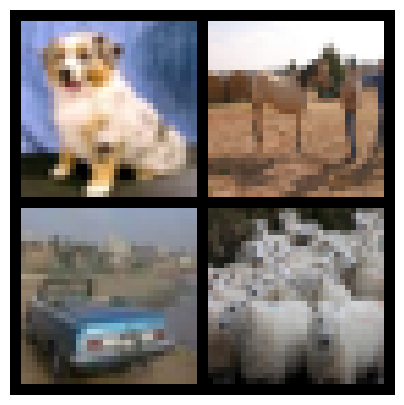

In [13]:
images, _ = next(iter(lance_train_loader))
draw_image_grid(images)

## Build the Model

A Variational Autoencoder (VAE) is very similar to a standard autoencoder in its structure and basic functionality. Both models consist of an encoder and a decoder. The encoder compresses the input into a latent representation, and the decoder reconstructs the input from this latent code. However, VAEs introduce several critical modifications that address some of the limitations of standard autoencoders, particularly regarding the generation of diverse and meaningful outputs.

### Key Components of the Variational Autoencoder

1. **Encoder**: The encoder in a VAE consists of several convolutional layers (in the case of images) that transform the input data into a lower-dimensional latent space. The encoder outputs the mean and variance parameters of the latent distribution, rather than a fixed latent code.

2. **Reparameterization**: The reparameterization trick allows the model to sample from the latent distribution in a differentiable manner. This step involves sampling a latent code from the Gaussian distribution defined by the mean and variance parameters output by the encoder.

3. **Decoder**: The decoder takes the sampled latent code and reconstructs the input data. It consists of several deconvolutional layers that gradually upsample the latent code back to the original input dimensions.

4. **Loss Function**: The VAE loss function comprises the reconstruction loss and the KL divergence loss. The reconstruction loss ensures that the output is a faithful reconstruction of the input, while the KL divergence loss regularizes the latent space.

Here's a high-level summary of how a VAE operates:

- **Encoding**: The input is passed through the encoder, which outputs the mean and variance of the latent distribution.
- **Sampling**: A latent code is sampled from this distribution using the reparameterization trick.
- **Decoding**: The sampled latent code is passed through the decoder to reconstruct the input.
- **Loss Calculation**: The loss function, combining reconstruction loss and KL divergence loss, is used to optimize the model.

By incorporating these probabilistic elements and regularization techniques, VAEs overcome some of the limitations of traditional autoencoders, particularly in terms of generating diverse and meaningful outputs. In the next sections, we will explore the technical implementation of a VAE, leveraging the Lance data format to optimize data handling and improve the efficiency of our workflows.

In [14]:
# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(vae_config["IN_CHANNELS"], 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(128*4*4, vae_config["LATENT_DIM_SIZE"])
        self.fc_logvar = nn.Linear(128*4*4, vae_config["LATENT_DIM_SIZE"])

        # Decoder
        self.decoder_input = nn.Linear(vae_config["LATENT_DIM_SIZE"], 128*4*4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, vae_config["IN_CHANNELS"], kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output values in range [-1, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        return self.decoder(z), mu, logvar

    def sample(self, num_samples):
        z = torch.randn(num_samples, vae_config["LATENT_DIM_SIZE"]).to(device)
        return self.decoder(self.decoder_input(z).view(-1, 128, 4, 4))

## Let's train our model

In [15]:
device = "cuda"

# Loss Function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [16]:
# Initialize model, optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=vae_config["LEARNING_RATE"])

Epoch 1/50: 100%|██████████| 704/704 [01:19<00:00,  8.90it/s, Loss=2.73e+3]

Epoch [1/50] Average Loss: 200.1048


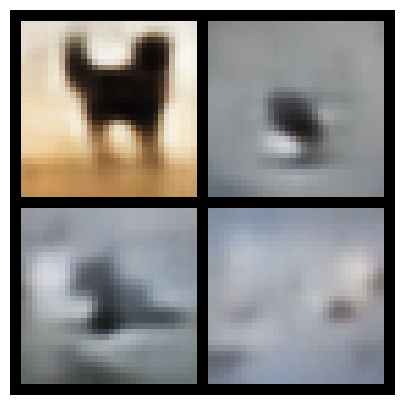

Epoch 2/50: 100%|██████████| 704/704 [01:18<00:00,  8.93it/s, Loss=3.28e+3]


Epoch [2/50] Average Loss: 199.6485


Epoch 3/50: 100%|██████████| 704/704 [01:18<00:00,  8.97it/s, Loss=3.28e+3]


Epoch [3/50] Average Loss: 199.2939


Epoch 4/50: 100%|██████████| 704/704 [01:21<00:00,  8.66it/s, Loss=2.91e+3]


Epoch [4/50] Average Loss: 198.7973


Epoch 5/50: 100%|██████████| 704/704 [01:21<00:00,  8.65it/s, Loss=3.36e+3]


Epoch [5/50] Average Loss: 198.5309


Epoch 6/50: 100%|██████████| 704/704 [01:21<00:00,  8.65it/s, Loss=3.07e+3]


Epoch [6/50] Average Loss: 198.3464


Epoch 7/50: 100%|██████████| 704/704 [01:20<00:00,  8.69it/s, Loss=3.36e+3]


Epoch [7/50] Average Loss: 198.0043


Epoch 8/50: 100%|██████████| 704/704 [01:19<00:00,  8.88it/s, Loss=3.08e+3]


Epoch [8/50] Average Loss: 197.7235


Epoch 9/50: 100%|██████████| 704/704 [01:19<00:00,  8.91it/s, Loss=3.18e+3]


Epoch [9/50] Average Loss: 197.3993


Epoch 10/50: 100%|██████████| 704/704 [01:19<00:00,  8.88it/s, Loss=2.88e+3]


Epoch [10/50] Average Loss: 197.3790


Epoch 11/50: 100%|██████████| 704/704 [01:18<00:00,  8.92it/s, Loss=3.04e+3]

Epoch [11/50] Average Loss: 197.0955


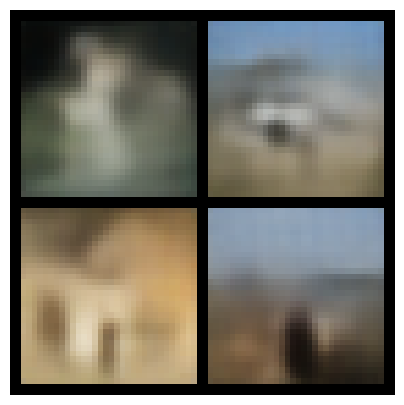

Epoch 12/50: 100%|██████████| 704/704 [01:19<00:00,  8.87it/s, Loss=2.91e+3]


Epoch [12/50] Average Loss: 196.9678


Epoch 13/50: 100%|██████████| 704/704 [01:19<00:00,  8.84it/s, Loss=2.83e+3]


Epoch [13/50] Average Loss: 196.8687


Epoch 14/50: 100%|██████████| 704/704 [01:19<00:00,  8.83it/s, Loss=3.15e+3]


Epoch [14/50] Average Loss: 196.6875


Epoch 15/50: 100%|██████████| 704/704 [01:19<00:00,  8.88it/s, Loss=3.14e+3]


Epoch [15/50] Average Loss: 196.4960


Epoch 16/50: 100%|██████████| 704/704 [01:20<00:00,  8.79it/s, Loss=3.11e+3]


Epoch [16/50] Average Loss: 196.3866


Epoch 17/50: 100%|██████████| 704/704 [01:19<00:00,  8.89it/s, Loss=3.12e+3]


Epoch [17/50] Average Loss: 196.2801


Epoch 18/50: 100%|██████████| 704/704 [01:19<00:00,  8.85it/s, Loss=2.82e+3]


Epoch [18/50] Average Loss: 196.1444


Epoch 19/50: 100%|██████████| 704/704 [01:19<00:00,  8.87it/s, Loss=3.34e+3]


Epoch [19/50] Average Loss: 196.0069


Epoch 20/50: 100%|██████████| 704/704 [01:19<00:00,  8.86it/s, Loss=2.88e+3]


Epoch [20/50] Average Loss: 195.9951


Epoch 21/50: 100%|██████████| 704/704 [01:18<00:00,  8.94it/s, Loss=3.15e+3]

Epoch [21/50] Average Loss: 195.8795


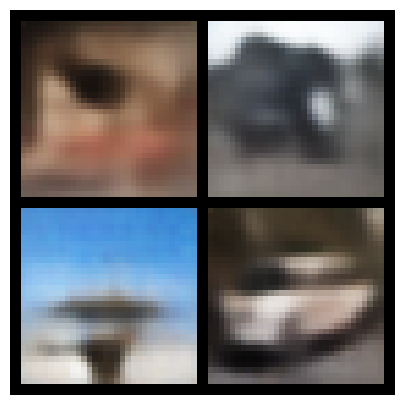

Epoch 22/50: 100%|██████████| 704/704 [01:18<00:00,  8.95it/s, Loss=3.26e+3]


Epoch [22/50] Average Loss: 195.7932


Epoch 23/50: 100%|██████████| 704/704 [01:18<00:00,  8.99it/s, Loss=2.71e+3]


Epoch [23/50] Average Loss: 195.7843


Epoch 24/50: 100%|██████████| 704/704 [01:18<00:00,  8.97it/s, Loss=3.64e+3]


Epoch [24/50] Average Loss: 195.5810


Epoch 25/50: 100%|██████████| 704/704 [01:18<00:00,  8.99it/s, Loss=2.47e+3]


Epoch [25/50] Average Loss: 195.5739


Epoch 26/50: 100%|██████████| 704/704 [01:18<00:00,  8.95it/s, Loss=3.64e+3]


Epoch [26/50] Average Loss: 195.4519


Epoch 27/50: 100%|██████████| 704/704 [01:18<00:00,  8.93it/s, Loss=3e+3]


Epoch [27/50] Average Loss: 195.4074


Epoch 28/50: 100%|██████████| 704/704 [01:18<00:00,  8.91it/s, Loss=3.28e+3]


Epoch [28/50] Average Loss: 195.3856


Epoch 29/50: 100%|██████████| 704/704 [01:19<00:00,  8.81it/s, Loss=3.13e+3]


Epoch [29/50] Average Loss: 195.3240


Epoch 30/50: 100%|██████████| 704/704 [01:22<00:00,  8.51it/s, Loss=3.23e+3]


Epoch [30/50] Average Loss: 195.2641


Epoch 31/50: 100%|██████████| 704/704 [01:23<00:00,  8.39it/s, Loss=2.92e+3]

Epoch [31/50] Average Loss: 195.2051


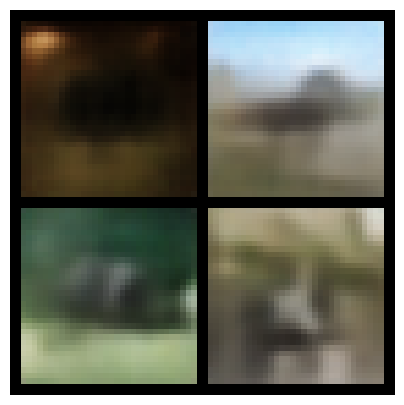

Epoch 32/50: 100%|██████████| 704/704 [01:24<00:00,  8.33it/s, Loss=3.02e+3]


Epoch [32/50] Average Loss: 195.1337


Epoch 33/50: 100%|██████████| 704/704 [01:25<00:00,  8.27it/s, Loss=3.02e+3]


Epoch [33/50] Average Loss: 195.0702


Epoch 34/50: 100%|██████████| 704/704 [01:25<00:00,  8.25it/s, Loss=3.42e+3]


Epoch [34/50] Average Loss: 195.0755


Epoch 35/50: 100%|██████████| 704/704 [01:24<00:00,  8.30it/s, Loss=3.12e+3]


Epoch [35/50] Average Loss: 195.0252


Epoch 36/50: 100%|██████████| 704/704 [01:24<00:00,  8.30it/s, Loss=3.07e+3]


Epoch [36/50] Average Loss: 195.0034


Epoch 37/50: 100%|██████████| 704/704 [01:24<00:00,  8.31it/s, Loss=2.99e+3]


Epoch [37/50] Average Loss: 194.8762


Epoch 38/50: 100%|██████████| 704/704 [01:22<00:00,  8.50it/s, Loss=3.33e+3]


Epoch [38/50] Average Loss: 194.8509


Epoch 39/50: 100%|██████████| 704/704 [01:20<00:00,  8.75it/s, Loss=3.02e+3]


Epoch [39/50] Average Loss: 194.8396


Epoch 40/50: 100%|██████████| 704/704 [01:20<00:00,  8.77it/s, Loss=2.83e+3]


Epoch [40/50] Average Loss: 194.8027


Epoch 41/50: 100%|██████████| 704/704 [01:18<00:00,  9.00it/s, Loss=2.92e+3]

Epoch [41/50] Average Loss: 194.7676


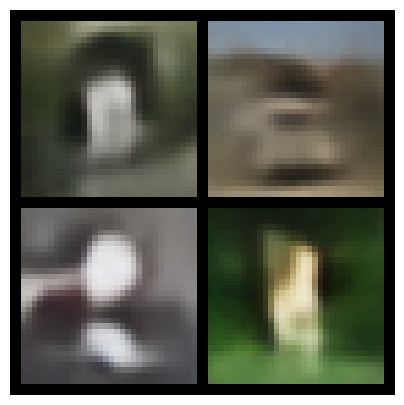

Epoch 42/50: 100%|██████████| 704/704 [01:17<00:00,  9.06it/s, Loss=2.97e+3]


Epoch [42/50] Average Loss: 194.7411


Epoch 43/50: 100%|██████████| 704/704 [01:17<00:00,  9.07it/s, Loss=3.28e+3]


Epoch [43/50] Average Loss: 194.6361


Epoch 44/50: 100%|██████████| 704/704 [01:16<00:00,  9.21it/s, Loss=2.87e+3]


Epoch [44/50] Average Loss: 194.6639


Epoch 45/50: 100%|██████████| 704/704 [01:16<00:00,  9.21it/s, Loss=3.19e+3]


Epoch [45/50] Average Loss: 194.6382


Epoch 46/50: 100%|██████████| 704/704 [01:16<00:00,  9.25it/s, Loss=2.58e+3]


Epoch [46/50] Average Loss: 194.5858


Epoch 47/50: 100%|██████████| 704/704 [01:15<00:00,  9.27it/s, Loss=2.71e+3]


Epoch [47/50] Average Loss: 194.6442


Epoch 48/50: 100%|██████████| 704/704 [01:16<00:00,  9.22it/s, Loss=3.04e+3]


Epoch [48/50] Average Loss: 194.5577


Epoch 49/50: 100%|██████████| 704/704 [01:16<00:00,  9.21it/s, Loss=3.44e+3]


Epoch [49/50] Average Loss: 194.5355


Epoch 50/50: 100%|██████████| 704/704 [01:16<00:00,  9.22it/s, Loss=3.1e+3]

Epoch [50/50] Average Loss: 194.4592


In [18]:
for epoch in range(vae_config["NUM_EPOCHS"]):
    model.train()
    train_loss = 0

    # Use tqdm for the progress bar
    pbar = tqdm(enumerate(lance_train_loader), total=len(lance_train_loader), desc=f'Epoch {epoch+1}/{vae_config["NUM_EPOCHS"]}')

    for batch_idx, (data, _) in pbar:
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # Update tqdm description with current loss
        pbar.set_postfix({'Loss': loss.item()})

    avg_loss = train_loss / len(lance_train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{vae_config["NUM_EPOCHS"]}] Average Loss: {avg_loss:.4f}')

    # show and display a sample of the reconstructed images
    if epoch % 10 == 0:
        with torch.no_grad():
            sampled_images = model.sample(num_samples=4)
            draw_image_grid(recon_batch.cpu())

## Let's see how we do on reconstruction

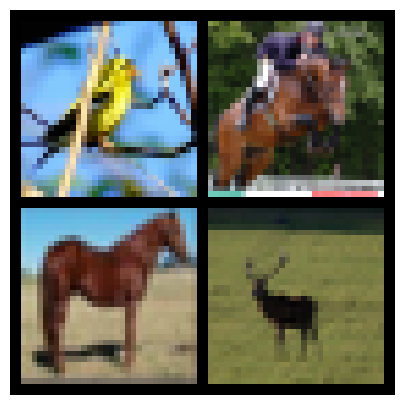

In [19]:
images, _ = next(iter(lance_train_loader))
draw_image_grid(images)

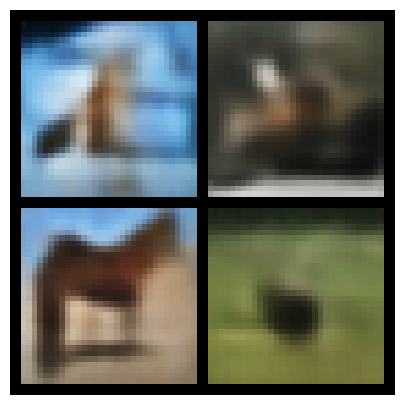

In [21]:
with torch.no_grad():
    recon_images, _, _ = model(images.to(device))
draw_image_grid(recon_images.cpu())